# Gaussian Process the LC

In [15]:
import os
#COCO_PATH=os.environ['COCO_PATH']
COCO_PATH="/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/"
DATALC_PATH = COCO_PATH+"/Inputs/Photometry/4_LCs_late_extrapolated/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/"

DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"

OUTPUT_DIR = COCO_PATH+"Outputs/"

import sys
sys.path.insert(0, COCO_PATH+'what_the_flux/')
import what_the_flux as wtf

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.optimize as opt

import george
from george.kernels import ExpSquaredKernel, ConstantKernel, Matern32Kernel

%matplotlib inline

In [17]:
info_objects = pd.read_csv(DATAINFO_PATH+'info.dat', comment='#', delimiter=' ')
name_type = dict(zip(info_objects['Name'], info_objects['Type']))

se_sne = [row.Name for i,row in info_objects.iterrows() if row.Type in ['IIb', 'Ib', 'Ic', 'Ic-BL', 'Ibc-pec']]
hydr_sne = [row.Name for i,row in info_objects.iterrows() if row.Type in ['IIn', 'II', 'IIL', 'IIP', '1987A', '87A']]

In [18]:
color_dict = {'Bessell_U': 'blue', 'Bessell_B': 'royalblue','Bessell_V':  'limegreen',
              'Bessell_R':  'red', 'Bessell_I':  'mediumvioletred',
              'sdss_g':'darkgreen','ptf_g':'darkgreen', "sdss_g'":'darkgreen','sdss_i':'indianred',
              "sdss_i'":'indianred','sdss_r': 'darkred', "sdss_r'":'darkred','sdss_z':'sienna', "sdss_z'":'sienna',
              'sdss_u': 'darkblue', "sdss_u'": 'darkblue', 'Y':'salmon','H':'darkred', 'J':  'k',
              'Ks':  'brown','K':  'brown', 'swift_UVW1':'indigo', 'swift_UVW2':'darkblue',
               'swift_UVM2':'darkmagenta','swift_U':'plum','swift_V':'teal','swift_B':'powderblue'}

mark_dict = {'Bessell_U': 'o','Bessell_B': 'o', 'Bessell_V':'o', 'Bessell_R':'o', 'Bessell_I': 'o', 
             'sdss_g':'s','ptf_g':'s', "sdss_g'":'s', 'sdss_i':'s', "sdss_i'":'s',
                'sdss_r':'s', "sdss_r'":'s', 'sdss_z':'s', "sdss_z'":'s', 'sdss_u': 's', "sdss_u'": 's',
                'Y':  'o','H':  'o', 'J':  'o', 'Ks':  'o','K':  'o',
                'swift_UVW1':'D', 'swift_UVW2':'D', 'swift_UVM2':'D', 'swift_U':'D',
                'swift_V':'D', 'swift_B':'D'}

exclude_filt = ['H', 'J', 'K', 'Ks','KS', 'Y']
#exclude_filt = ['KS']

pre_bump = ['SN2011dh','SN1993J','SN2008D','SN2011fu','SN2006aj','SN1987A','SN2013df']


In [19]:
def err_to_log10(flux, err_flux):
    flux=np.array(flux, dtype=float)
    err_flux=np.array(err_flux, dtype=float)
    return 1./np.log(10.) * err_flux/flux

def err_from_log10(logflux, logerr_flux):
    return np.log(10.) * 10**logflux * logerr_flux



In [20]:
class SNPhotometryClass():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self,snname, verbose=False):
        """
        """
        ## Initialise the class variables
        self.lc_data_path = DATALC_PATH
        self.snname = snname   
        self.set_data_directory(verbose)

    def set_data_directory(self, verbose):
        """
        Set a new data directory path.
        Enables the data directory to be changed by the user.
        """
        SNphotometry_PATH = os.path.join(self.lc_data_path, '%s.dat'%self.snname)
        
        try:
            if verbose: print('Looking for Photometry for %s in%s'%(self.snname, SNphotometry_PATH))
            if os.path.isfile(SNphotometry_PATH):
                if verbose: print ('Got it!')
                self.sn_rawphot_file = SNphotometry_PATH
                pass
            else:
                if not os.path.isdir(self.lc_data_path):
                    print ('I cant find the directory with photometry. Check %s'%self.lc_data_path)
                    pass
                else: 
                    print ('I cant find the file with photometry. Check %s'%SNphotometry_PATH)
                    pass
    
        except Exception as e:
            print (e)

    def load(self, verbose = False):
        """
        Loads a single photometry file.
        with ('MJD', 'Flux', 'Flux_err', 'band')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        if verbose: print('Loading %s'%self.sn_rawphot_file)
        try:
            lc_file = np.genfromtxt(self.sn_rawphot_file, dtype=None, encoding="utf-8", 
                                    names=True)
            mask_filt = np.array([f not in exclude_filt for f in lc_file['band']])
            lc_no_badfilters = lc_file[mask_filt]
            mask_filt = np.array([~np.isnan(f) for f in lc_no_badfilters['Flux']])
            self.phot = lc_no_badfilters[mask_filt]
            
            #filtname_filtset = [fn+'__'+fs for fn,fs in zip(self.phot['band'], self.phot['FilterSet'])]
            self.avail_filters = np.unique(self.phot['band'])

            self.clipped_phot = self.phot
            print ('Photometry loaded')

            
        except Exception as e:
            print (e)
            print ('Are you sure you gave me the right format? Check documentation in case.')

    def get_availfilter(self, verbose = False):
        """
        get available filter for this SN
        """
        #if photometry is not already loaded, load it!
        if (not hasattr(self, "phot"))|(not hasattr(self, "avail_filters")):
            self.load()
        return self.avail_filters
        
    def get_singlefilter(self, single_filter, extended_clipped = False, verbose = False):
        """
        Loads from photometry file just 1 filter photometry.
        with ('MJD', 'Flux', 'Flux_err', 'band')
        
        Parameters
        - verbose
        ----------
        Returns
        - photometry in all filters
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()

        if not (isinstance(single_filter, str)):
            print ('Single filter string please')
            return None
        
        if single_filter not in self.avail_filters:
            print ('Looks like the filter you are looking for is not available')
            return None
        
        if extended_clipped:
            if not hasattr(self, "clipped_phot"):
                self.clip_photometry()
            filt_index = self.clipped_phot['band']==single_filter
            return self.clipped_phot[filt_index] 
        else: 
            filt_index = self.phot['band']==single_filter
            return self.phot[filt_index]
        
    
    def get_mjdpeak(self, verbose = False):
        """
        Loads from photometry for each filter, measure peak for each filter
        get a rough estimate of the paek_mjd
        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
            
        mjd_peaks_list=[]
        for f in self.avail_filters:
            phot_perfilt = self.get_singlefilter(f)
            mjd_peak = phot_perfilt['MJD'][np.argmax(phot_perfilt['Flux'])]
            mjd_peaks_list.append(mjd_peak)
            
        return np.min(mjd_peaks_list)
    
    def plot_raw_phot(self, filt_list=None, plt_extended_clipped=False, save_fig=False, \
                      save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        if (plt_extended_clipped)&(not hasattr(self, "clipped_phot")):
            self.extend_photometry()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f, extended_clipped=plt_extended_clipped)
            plt.errorbar(phot_f['MJD'], phot_f['Flux'], phot_f['Flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None

    def plot_GP_fit_phot(self, filt_list=None, save_fig=False, save_format='png', output_path_name=None):
        
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        if not hasattr(self, "gp"):
            self.load()

        if filt_list:
            filt_toplot = filt_list
        else:
            filt_toplot = self.avail_filters
        fig = plt.figure(1)
        for f in filt_toplot:
            phot_f = self.get_singlefilter(f)
            plt.errorbar(phot_f['MJD'], phot_f['Flux'], yerr=phot_f['Flux_err'],\
                         marker='.', linestyle='None', label=f)
        plt.legend(loc='best')
        plt.show()
        if save_fig:
            if output_path_name:
                fig.savefig(output_path_name)
            else:
                fig.savefig(self.sn_rawphot_file.replace('.dat', '_raw_photo.%s'%save_format))
        return None


    def clip_LC_filter(self, filter_name, clipping_mjd_delta = 0.5, pre_bump=False):
        
        def clip_one_point(mjd_unclipped, flux_unclipped, fluxerr_unclipped, filtset_unclipped, instr_unclipped, clipping_index):
            mjd_tbc = np.array([mjd_unclipped[clipping_index], mjd_unclipped[clipping_index+1]])
            flux_tbc = np.array([flux_unclipped[clipping_index], flux_unclipped[clipping_index+1]])
            flux_err_tbc = np.array([fluxerr_unclipped[clipping_index], fluxerr_unclipped[clipping_index+1]])
            mjd_avg = np.average(mjd_tbc)
            flux_avg, sum_w = np.average(flux_tbc, weights= 1./(flux_err_tbc)**2, returned=True)
            flux_err_avg = max([np.std(flux_tbc), np.sqrt(1./sum_w)])
            clipped_mjd_sorted = np.delete(mjd_unclipped, clipping_index)
            clipped_flux_sorted = np.delete(flux_unclipped, clipping_index)
            clipped_flux_err_sorted = np.delete(fluxerr_unclipped, clipping_index)
            clipped_filtset_sorted = np.delete(filtset_unclipped, clipping_index)
            clipped_instr_sorted = np.delete(instr_unclipped, clipping_index)
            clipped_mjd_sorted[clipping_index] = mjd_avg
            clipped_flux_sorted[clipping_index] = flux_avg
            clipped_flux_err_sorted[clipping_index] = flux_err_avg
            #print ('I clipped index:', clipping_index, ' Lenght was %i, now is %i '%(len(mjd_unclipped), len(clipped_mjd_sorted)))
            return clipped_mjd_sorted, clipped_flux_sorted, clipped_flux_err_sorted, clipped_filtset_sorted, clipped_instr_sorted
    
        LC_filt = self.get_singlefilter(filter_name)
        mjd_sorted = np.sort(LC_filt['MJD'])
        flux_sorted = LC_filt['Flux'][np.argsort(LC_filt['MJD'])]
        flux_err_sorted = LC_filt['Flux_err'][np.argsort(LC_filt['MJD'])]
        filtset_sorted = LC_filt['FilterSet'][np.argsort(LC_filt['MJD'])]
        instr_sorted = LC_filt['Instr'][np.argsort(LC_filt['MJD'])]
        
        if pre_bump:
            mask_bump = mjd_sorted>min(mjd_sorted)+10.
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])[mask_bump]
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)[mask_bump]
            new_flux_err_sorted = np.copy(flux_err_sorted)[mask_bump]
            new_filtset_sorted = np.copy(filtset_sorted)[mask_bump]
            new_Instr_sorted = np.copy(instr_sorted)[mask_bump]
        else:
            new_mjd_sorted = np.array([round(m,2) for m in mjd_sorted])
            double = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)
            new_flux_sorted = np.copy(flux_sorted)
            new_flux_err_sorted = np.copy(flux_err_sorted)
            new_filtset_sorted = np.copy(filtset_sorted) 
            new_Instr_sorted = np.copy(instr_sorted) 
            
        while len(np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0])>=1:
            tbc_indexes = np.where(np.abs(new_mjd_sorted[:-1]-new_mjd_sorted[1:])<clipping_mjd_delta)[0]
            ind = tbc_indexes[0]
            R = clip_one_point(new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted, ind)
            new_mjd_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted = R

        if pre_bump:
            new_mjd_sorted = np.concatenate([mjd_sorted[~mask_bump], new_mjd_sorted])
            new_flux_sorted = np.concatenate([flux_sorted[~mask_bump], new_flux_sorted])
            new_flux_err_sorted = np.concatenate([flux_err_sorted[~mask_bump], new_flux_err_sorted])
            new_filtset_sorted = np.concatenate([filtset_sorted[~mask_bump], new_filtset_sorted])       
            new_Instr_sorted = np.concatenate([instr_sorted[~mask_bump], new_Instr_sorted])       

        new_filter_sorted = np.full(len(new_mjd_sorted), filter_name, dtype='|S20')
        new_LC=[]
        for i in zip(new_mjd_sorted, new_filter_sorted, new_flux_sorted, new_flux_err_sorted, new_filtset_sorted, new_Instr_sorted):
            new_LC.append(i)
        new_LC = np.array(new_LC, LC_filt.dtype)
        
        print (filter_name, 'Before clipping %i, after %i'%(len(mjd_sorted), len(new_LC)))
        return new_LC
    
    def clip_photometry(self, pre_bump=False, verbose = False):
        """
        Clip photometry in every filter        
        Parameters
        - verbose
        ----------
        Returns
        - rough estimate of the peak_mjd
        -------
        """
        #if photometry is not already loaded, load it!
        if not hasattr(self, "phot"):
            self.load()
        
        filt_avail = self.avail_filters
        
        clipping_mjd_delta = 1.0
        LC_clipped = np.array([], self.phot.dtype) 
        for ff in filt_avail:
            LC_xfilter = self.clip_LC_filter(ff, clipping_mjd_delta, pre_bump=pre_bump)
            LC_clipped = np.concatenate([LC_clipped, LC_xfilter])
        self.clipped_phot = LC_clipped
        return None
    
    def get_spec_mjd(self, verbose=False):
        phase_list_file = DATASPEC_PATH + '2_spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding="utf-8")
            return parse_phase['f0']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
        
    def get_spec_list(self, verbose=False):
        phase_list_file = DATASPEC_PATH + '/2_spec_lists_smoothed/' + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None,encoding="utf-8")
            
            return parse_phase['f2']
        except: 
            print ('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])

    def LCfit_withGP_xfilter(self, filt, minMJD=None, maxMJD=None):
        if not hasattr(self, "phot"):
            self.load()

        def ll(p):
            gp.set_parameter_vector(p)
            return -gp.lnlikelihood(flux_norm, quiet=False)#

        # gradient of the  liklihood for optimisation of the kernel size

        def grad_ll(p):
            gp.set_parameter_vector(p)
            return -gp.grad_lnlikelihood(flux_norm, quiet=False)
                        
        mjd_peak = self.get_mjdpeak()
        
        mjd_spectra = self.get_spec_mjd()
        if minMJD is None:
            #minMJD= min([mjd_peak-15.,np.min(self.clipped_phot['MJD'])])  #np.min(self.clipped_phot['MJD'])
            minMJD= min([min(mjd_spectra),np.min(self.clipped_phot['MJD'])])  #np.min(self.clipped_phot['MJD'])
        if maxMJD is None:
            #maxMJD= min([max(mjd_spectra),np.max(self.phot['MJD'])])
            maxMJD= min([minMJD+300.,np.max(self.phot['MJD'])])
        
        print ('MJD range', maxMJD-minMJD)
        new_mjd = np.arange(minMJD-1., maxMJD+1., 0.05)

        LC_filt_extended = self.get_singlefilter(filt, extended_clipped=True)
        mjd = LC_filt_extended['MJD']
        mjdT = np.atleast_2d(mjd).T
        
        orig_flux = (LC_filt_extended['Flux'])
        orig_flux_err = LC_filt_extended['Flux_err']

        if TRY_LOG:
            flux_gp = np.log(LC_filt_extended['Flux'])
            flux_err_gp = LC_filt_extended['Flux_err']/LC_filt_extended['Flux']
        else:
            flux_gp = (LC_filt_extended['Flux'])
            flux_err_gp = LC_filt_extended['Flux_err']

        norm = np.max(flux_gp)#np.median(flux_gp)
        flux_norm = flux_gp/norm
        err_flux_norm = flux_err_gp/norm
                                
        if (self.snname in list(kernel_settings_dict.keys())):
            if filt in list(kernel_settings_dict[self.snname].keys()):
                set_scale = kernel_settings_dict[self.snname][filt]['scale']
                set_optimization = kernel_settings_dict[self.snname][filt]['opt']
                set_mean = kernel_settings_dict[self.snname][filt]['mean']
            else:
                set_scale, set_optimization, set_mean = set_default_kernel_settings(filt)
        else:
            set_scale, set_optimization, set_mean = set_default_kernel_settings(filt)
        if set_mean: set_fit_mean = True
        else: set_fit_mean=False
            
        k= np.var(flux_norm)* Matern32Kernel(set_scale)
        gp = george.GP(k, mean=set_mean, fit_mean=set_fit_mean)#, 
                       #white_noise=10**-5, fit_white_noise=True)
        
        gp.compute(mjdT, err_flux_norm)
        if set_optimization:
            p0=gp.get_parameter_vector()
            results = opt.minimize(ll, p0, jac=grad_ll)
        print ('results ',filt, np.exp(gp.get_parameter_vector()))
        mu_gp, cov = gp.predict(flux_norm, new_mjd)
        std_gp = np.sqrt(np.diag(cov))
        
        if TRY_LOG:
            mu = np.exp(mu_gp*norm)
            std =  np.abs(mu*std_gp*norm)
        else:
            mu = mu_gp*norm
            std =  std_gp*norm
        #if filt != 'Bessell_V':

        mu_mjdspec, cov_mjdspec = gp.predict(flux_norm, mjd_spectra)
        std_mjdspec = np.sqrt(np.diag(cov_mjdspec))
        mu_mjdspec = (mu_mjdspec*norm)
        std_mjdspec =(std_mjdspec*norm)
        
        sudo_pts = LC_filt_extended['FilterSet']=='SUDO_PTS'
        self.fitted_phot[filt] = {'clipped_extended_data': [mjd, orig_flux, orig_flux_err, sudo_pts],
                                  'fit_highcadence':  [new_mjd, mu, std],
                                 'fit_mjdspec':  [mjd_spectra, mu_mjdspec, std_mjdspec]}
        return None


    def LCfit_withGP(self, minMJD=None, maxMJD=None):
        if not hasattr(self, "phot"):
            self.load()

        if not hasattr(self, "fitted_phot"):
            print ('Computing GP fit (for the first time)')
            self.fitted_phot = dict(zip(self.avail_filters, np.zeros(len(self.avail_filters))))
        else:
            print ('Forcing to do GP fit again')
            self.fitted_phot = dict(zip(self.avail_filters, np.zeros(len(self.avail_filters))))
        
        for f in self.avail_filters:
            self.LCfit_withGP_xfilter(f, minMJD=minMJD, maxMJD=maxMJD)
        return None
        
        
    def save_plot_GPfit(self, save_fig_output=None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")


        max_flux = [10**-20]
        fig = plt.figure(figsize=(14,6))
        plt.rc('font', family='serif')
        plt.rc('xtick', labelsize=13)
        plt.rc('ytick', labelsize=13)
        for f in self.avail_filters:
            c = color_dict[f]
            mjd, flux, err_flux, sudo_mask = self.fitted_phot[f]['clipped_extended_data'] 
            
            new_mjd, mu, std= self.fitted_phot[f]['fit_highcadence'] 

            if 'swift' in f: flabel = f.split('_')[1]+'(Swift)'
            else: flabel = f.split('_')[1]
            a=plt.errorbar(mjd[~sudo_mask], flux[~sudo_mask], yerr=err_flux[~sudo_mask],
                           fmt=mark_dict[f],mfc= c, ms =5, color= c,
                           linestyle='None', label=flabel)
            a=plt.errorbar(mjd[sudo_mask], flux[sudo_mask], yerr=err_flux[sudo_mask], 
                           fmt=mark_dict[f], mfc='white',mec=c, ms=5, mew=0.5, color= c,linestyle='None')

            plt.plot(new_mjd, mu, color=a[0].get_color())#, label=flabel)
            plt.fill_between(new_mjd, (mu+std), (mu-std), color=a[0].get_color(), alpha=0.1)
            max_flux.append(max(flux))

        plt.vlines(self.get_spec_mjd(), max(max_flux)*0.95, max(max_flux)*1.085, lw=0.8,
                   linestyle='-', color='k', label='Spectra')
        try:
            #plt.xlim(min(self.clipped_phot['MJD'])-2., 
            #         min(max(self.clipped_phot['MJD']), min(self.clipped_phot['MJD'])+180.))#max(self.get_spec_mjd())+10.)
            max_x = min(self.clipped_phot['MJD'])+180. if self.snname in hydr_sne else min(self.clipped_phot['MJD'])+80.
            plt.xlim(min(self.clipped_phot['MJD'])-2., max_x)#max(self.get_spec_mjd())+10.)
        except:
            plt.xlim(min(self.clipped_phot['MJD'])-2., max(self.clipped_phot['MJD']))

        plt.xlabel(r'Time (MJD)', fontsize=13)
        plt.ylabel(r'Flux ($\mathrm{erg}$ $\mathrm{s^{-1} cm^{-2}} \mathrm{\AA} $)', fontsize=13)
        plt.ylim(-0.01*max(max_flux), max(max_flux)*1.1)
        plt.legend(fontsize=13, ncol=2, loc='center right', fancybox=True, framealpha=0.5)
        plt.title(self.snname+' light curve fitting using Gaussian Processes', fontsize=15)
        if save_fig_output is None:
            fig.savefig(self.results_mainpath+'fittedGP_%s_.pdf'%self.snname, bbox_inches='tight')
        else:
            fig.savefig(save_fig_output, bbox_inches='tight')
        return None
    
    def save_plot_GPfit_spec(self, save_fig_output=None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.""")
        fig = plt.figure(figsize=(9,4))
        max_flux=[];min_flux=[]
        for f in self.avail_filters:
            c = color_dict[f]
            hc_mjd, hc_mu, hc_std = self.fitted_phot[f]['fit_highcadence'] 
            new_mjd, mu, std= self.fitted_phot[f]['fit_mjdspec'] 
            minmjd = (min(self.get_singlefilter(f, extended_clipped=False)['MJD'])-1)
            maxmjd = (max(self.get_singlefilter(f, extended_clipped=False)['MJD'])+1)
            inrange = (new_mjd>=minmjd)&(new_mjd<= maxmjd)
            a=plt.errorbar(new_mjd[inrange], mu[inrange], yerr=std[inrange], fmt=mark_dict[f], 
                           mfc= c, ms=3, elinewidth=0.8, color= c,linestyle='None')
            plt.plot(hc_mjd, hc_mu, color=a[0].get_color(), label=f, alpha=0.3)
            max_flux.append(max(hc_mu[~np.isnan(hc_mu)])); min_flux.append(min(hc_mu[~np.isnan(hc_mu)]))
        if len(new_mjd)==0: new_mjd, mu, std, sudo_mask= self.fitted_phot[f]['clipped_extended_data'] 
        plt.ylim(max(max_flux)*0.01, max(max_flux))
        plt.yscale('log')
        plt.title(self.snname+' fitted photometry for mangling')
        if save_fig_output is None:
            fig.savefig(self.results_mainpath+'fittedGPspec_%s_.pdf'%self.snname, bbox_inches='tight')
        else:
            fig.savefig(save_fig_output,bbox_inches='tight')
        return None
        

    def mangling_GPfile(self, name_file = None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")
            
        fit_result2mangling = pd.DataFrame()
        fit_result2mangling['spec_file'] = self.get_spec_list()
        fit_result2mangling['spec_mjd'] = self.get_spec_mjd()

        for f in self.avail_filters:
            minmjd = int(min(self.get_singlefilter(f, extended_clipped=False)['MJD'])-1)
            maxmjd = int(max(self.get_singlefilter(f, extended_clipped=False)['MJD'])+1)
            mjd, flux, err_flux = self.fitted_phot[f]['fit_mjdspec'] 
            inrange = np.array([ (int(m)>= minmjd)&(int(m)<= maxmjd) for m in mjd])
            #inrange = np.array([ ((m)>= minmjd)&((m)<= maxmjd) for m in mjd])
            fit_result2mangling[f+'_fitflux'] = flux
            fit_result2mangling[f+'_fitfluxerr'] = err_flux
            fit_result2mangling[f+'_inrange'] = inrange
        
        fit_result2mangling.to_csv(self.results_mainpath+'fitted_phot4mangling_%s.dat'%self.snname,\
                                  sep='\t', index=False)
        return fit_result2mangling

    def full_fitted_LC_file(self, name_file = None):
        if not hasattr(self, "results_mainpath"):
            self.create_results_folder()

        if not hasattr(self, "fitted_phot"):
            self.LCfit_withGP()
        else:
            print ("""LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.""")
        
        df = pd.DataFrame()
        mjds = self.fitted_phot[self.avail_filters[0]]['fit_highcadence'][0]
        df['MJD'] = mjds
        
        for i in self.avail_filters:
            lc_filt = self.get_singlefilter(i)
            min_mjd = min(lc_filt['MJD'])
            max_mjd = max(lc_filt['MJD'])
            flux = self.fitted_phot[i]['fit_highcadence'][1]
            flux_err = self.fitted_phot[i]['fit_highcadence'][2]
            mask_out = (mjds<=min_mjd)|(mjds>=max_mjd)
            flux[mask_out] = np.nan
            flux_err[mask_out] = np.nan
            df[i] = flux
            df[i+'_err'] = flux_err
        
        df.to_csv(self.results_mainpath+'fitted_phot_%s.dat'%self.snname,\
                                  sep='\t', index=False,na_rep='nan')
        return df
    
    def create_results_folder(self):
        results_directory = OUTPUT_DIR+'/%s/'%self.snname
        if not os.path.exists(results_directory):
            os.makedirs(results_directory)
        self.results_mainpath = results_directory


In [23]:
def set_default_kernel_settings(filt):
    if filt not in ['swift_UVW1', 'swift_UVM2','swift_UVW2', 'Bessell_U', 'swift_U']:
        return 150., True, None
    elif filt in ['swift_UVW1', 'swift_UVM2','swift_UVW2', 'Bessell_U', 'swift_U']:
        return 150., True, None


kernel_settings_dict = {
 'ASASSN14jb': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 1000},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 1000},
  'sdss_g': {'mean': None, 'opt': False, 'scale': 1000},
  'sdss_r': {'mean': None, 'opt': False, 'scale': 1000},
  'swift_B': {'mean': None, 'opt': False, 'scale': 100},
  'swift_U': {'mean': None, 'opt': False, 'scale': 100}},
 'ASASSN15oz': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 500},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 500},
  'sdss_i': {'mean': None, 'opt': False, 'scale': 1500},
  'sdss_r': {'mean': None, 'opt': False, 'scale': 1500},
  'swift_U': {'mean': 0.2, 'opt': False, 'scale': 70},
  'swift_UVM2': {'mean': 0.2, 'opt': False, 'scale': 40},
  'swift_UVW1': {'mean': 0.2, 'opt': False, 'scale': 40},
  'swift_UVW2': {'mean': 0.5, 'opt': False, 'scale': 40}},
 'SN1993J': {'Bessell_R': {'mean': None, 'opt': False, 'scale': 10}},
 'SN1994I': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 800},
  'Bessell_U': {'mean': None, 'opt': False, 'scale': 100}},
 'SN1999dn': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 400},
  'Bessell_R': {'mean': None, 'opt': False, 'scale': 400},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 400}},
 'SN1999em': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 1000},
  'Bessell_I': {'mean': None, 'opt': False, 'scale': 1000},
  'Bessell_R': {'mean': None, 'opt': False, 'scale': 1000},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 1000}},
 'SN2004aw': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 100},
  'Bessell_I': {'mean': None, 'opt': False, 'scale': 100},
  'Bessell_R': {'mean': None, 'opt': False, 'scale': 100},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2004et': {'Bessell_B': {'mean': 0.7, 'opt': False, 'scale': 2000},
  'Bessell_R': {'mean': 0.7, 'opt': False, 'scale': 2000},
  'Bessell_V': {'mean': 0.7, 'opt': False, 'scale': 2000}},
 'SN2004fe': {'sdss_u': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2004gq': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 70},
  'sdss_u': {'mean': None, 'opt': False, 'scale': 70}},
 'SN2004gv': {'sdss_u': {'mean': None, 'opt': False, 'scale': 70}},
 'SN2004gt': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 300},
  'sdss_g': {'mean': None, 'opt': False, 'scale': 300},
  'sdss_r': {'mean': None, 'opt': False, 'scale': 300}},
 'SN2005cs': {'Bessell_B': {'mean': 1, 'opt': False, 'scale': 200},
  'Bessell_V': {'mean': 1, 'opt': False, 'scale': 500}},
 'SN2006aj': {'swift_B': {'mean': None, 'opt': False, 'scale': 100},
  'swift_U': {'mean': None, 'opt': False, 'scale': 100},
  'swift_UVW1': {'mean': None, 'opt': False, 'scale': 100},
  'swift_UVW2': {'mean': 0.1, 'opt': False, 'scale': 3},
  'swift_V': {'mean': None, 'opt': False, 'scale': 40}},
 'SN2006ep': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 500},
  'sdss_g': {'mean': None, 'opt': False, 'scale': 500},
  'sdss_u': {'mean': None, 'opt': False, 'scale': 50}},
 'SN2007Y': {'swift_UVM2': {'mean': 0.5, 'opt': False, 'scale': 50}},
 'SN2007gr': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 150},
  'Bessell_U': {'mean': 0.5, 'opt': False, 'scale': 70}},
 'SN2007od': {'Bessell_V': {'mean': None, 'opt': False, 'scale': 200}},
 'SN2007pk': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 300},
  'Bessell_R': {'mean': None, 'opt': False, 'scale': 300},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 300},
  'swift_U': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2007ru': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 1000},
  'Bessell_R': {'mean': None, 'opt': False, 'scale': 1200},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 1200}},
 'SN2008D': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 300},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 300},
  "sdss_i'": {'mean': None, 'opt': False, 'scale': 300},
  "sdss_r'": {'mean': None, 'opt': False, 'scale': 300},
  'swift_U': {'mean': None, 'opt': False, 'scale': 50},
  'swift_UVW1': {'mean': 0.5, 'opt': False, 'scale': 200}},
 'SN2008bj': {'Bessell_V': {'mean': None, 'opt': False, 'scale': 200},
  "sdss_i'": {'mean': None, 'opt': False, 'scale': 500}},
 'SN2008bo': {'swift_U': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2008in': {'Bessell_V': {'mean': 0.6, 'opt': False, 'scale': 500},
             'swift_U': {'mean': 0., 'opt': False, 'scale': 100}},
 'SN2009bw': {'Bessell_U': {'mean': None, 'opt': False, 'scale': 100},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 2000}},
 'SN2009dd': {'Bessell_U': {'mean': 0.1, 'opt': False, 'scale': 100},
  'Bessell_V': {'mean': 0.05, 'opt': False, 'scale': 500}},
 'SN2009ib': {"sdss_u'": {'mean': 3.0, 'opt': False, 'scale': 50}},
 'SN2009jf': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 1000}},
 'SN2009kr': {'Bessell_V': {'mean': None, 'opt': False, 'scale': 1000}},
 'SN2011dh': {'Bessell_R': {'mean': None, 'opt': False, 'scale': 50},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 50},
  "sdss_g'": {'mean': None, 'opt': False, 'scale': 50}},
 'SN2011ei': {'swift_U': {'mean': None, 'opt': False, 'scale': 50}},
 'SN2011fu': {'Bessell_R': {'mean': None, 'opt': False, 'scale': 70},
  'Bessell_U': {'mean': 0.05, 'opt': False, 'scale': 100},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 70}},
 'SN2011hs': {"sdss_u'": {'mean': None, 'opt': False, 'scale': 40}},
 'SN2011ht': {'Bessell_I': {'mean': None, 'opt': False, 'scale': 700},
  'Bessell_R': {'mean': None, 'opt': False, 'scale': 700},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 700}},
 'SN2012A': {'Bessell_V': {'mean': None, 'opt': False, 'scale': 1000}},
 'SN2012au': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 100},
  'swift_U': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2012aw': {'Bessell_U': {'mean': None, 'opt': False, 'scale': 500},
  'swift_UVW1': {'mean': None, 'opt': False, 'scale': 50},
  'swift_UVW2': {'mean': None, 'opt': False, 'scale': 50}},
 'SN2013ab': {'Bessell_I': {'mean': None, 'opt': False, 'scale': 500},
  'Bessell_V': {'mean': None, 'opt': False, 'scale': 500},
  'Bessell_B': {'mean': None, 'opt': False, 'scale': 500},
  'sdss_g': {'mean': None, 'opt': False, 'scale': 500},
  'swift_U': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2013am': {'Bessell_I': {'mean': 0.5, 'opt': False, 'scale': 1000},
  'Bessell_R': {'mean': 0.7, 'opt': False, 'scale': 500},
  'Bessell_V': {'mean': 0.8, 'opt': False, 'scale': 80},
  'sdss_i': {'mean': None, 'opt': False, 'scale': 500}},
 'SN2013by': {'swift_UVM2': {'mean': 0.8, 'opt': False, 'scale': 50},
  'swift_UVW1': {'mean': 0.8, 'opt': False, 'scale': 50},
  'swift_UVW2': {'mean': 0.8, 'opt': False, 'scale': 50}},
 'SN2013df': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 200},
  'Bessell_I': {'mean': None, 'opt': False, 'scale': 1000},
  'Bessell_U': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2013ej': {'Bessell_U': {'mean': None, 'opt': False, 'scale': 35}},
 'SN2013fs': {'Bessell_B': {'mean': 0.1, 'opt': False, 'scale': 1000},
  'Bessell_I': {'mean': 0.1, 'opt': False, 'scale': 1000},
  'Bessell_V': {'mean': 0.1, 'opt': False, 'scale': 700},
  'swift_UVM2': {'mean': None, 'opt': False, 'scale': 40},
  'swift_UVW1': {'mean': None, 'opt': False, 'scale': 40},
  'swift_UVW2': {'mean': None, 'opt': False, 'scale': 40}},
 'SN2013ge': {'Bessell_V': {'mean': None, 'opt': False, 'scale': 300},
  'swift_U': {'mean': None, 'opt': False, 'scale': 50}},
 'SN2014G': {'Bessell_U': {'mean': None, 'opt': False, 'scale': 1000},
  'swift_UVW1': {'mean': None, 'opt': False, 'scale': 25}},
 'SN2016X': {'Bessell_U': {'mean': None, 'opt': False, 'scale': 100}},
 'SN2016gkg': {'Bessell_B': {'mean': None, 'opt': False, 'scale': 1000}},
 'iPTF13bvn': {'swift_UVW2': {'mean': 0.6, 'opt': False, 'scale': 20}}}

In [24]:
TRY_LOG=False

In [25]:
SN = SNPhotometryClass(snname='AT2017gfo', verbose=True)

Looking for Photometry for AT2017gfo in/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Photometry/4_LCs_late_extrapolated/AT2017gfo.dat
Got it!


In [26]:
SN.load()
SN.get_availfilter()
SN.clip_photometry()

Photometry loaded
Bessell_B Before clipping 26, after 8
Bessell_I Before clipping 1, after 1
Bessell_U Before clipping 3, after 1
Bessell_V Before clipping 43, after 5
sdss_g Before clipping 34, after 7
sdss_i Before clipping 41, after 8
sdss_r Before clipping 37, after 5
sdss_z Before clipping 29, after 9


In [27]:
SN.LCfit_withGP()

Computing GP fit (for the first time)
MJD range 19.572000000000116
results  Bessell_B [0.17233075 5.48850737]
MJD range 19.572000000000116
results  Bessell_I [  0. 150.]
MJD range 19.572000000000116
results  Bessell_U [  0. 150.]
MJD range 19.572000000000116
results  Bessell_V [  0.23203862 215.76063475]
MJD range 19.572000000000116
results  sdss_g [ 0.2220432  22.34314391]
MJD range 19.572000000000116
results  sdss_i [ 0.23470346 24.11061702]
MJD range 19.572000000000116
results  sdss_r [  0.52432606 403.11282099]
MJD range 19.572000000000116
results  sdss_z [ 0.19620891 80.51872742]


/opt/anaconda3/envs/SED/lib/python3.12/site-packages/george/kernels.py:94: RuntimeWarning: divide by zero encountered in log
  log_constant = np.log(float(b)/self.ndim)


In [28]:
df = SN.full_fitted_LC_file()

LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.


LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.
LC fit already done. I will use the one that it.s available.
If you want to do again the LC fit call the function self.LCfit_withGP() again.
LC fit already done. I will use the one that it.s available.
If you want to do a
gain the LC fit call the function self.LCfit_withGP() again.


ValueError: max() iterable argument is empty

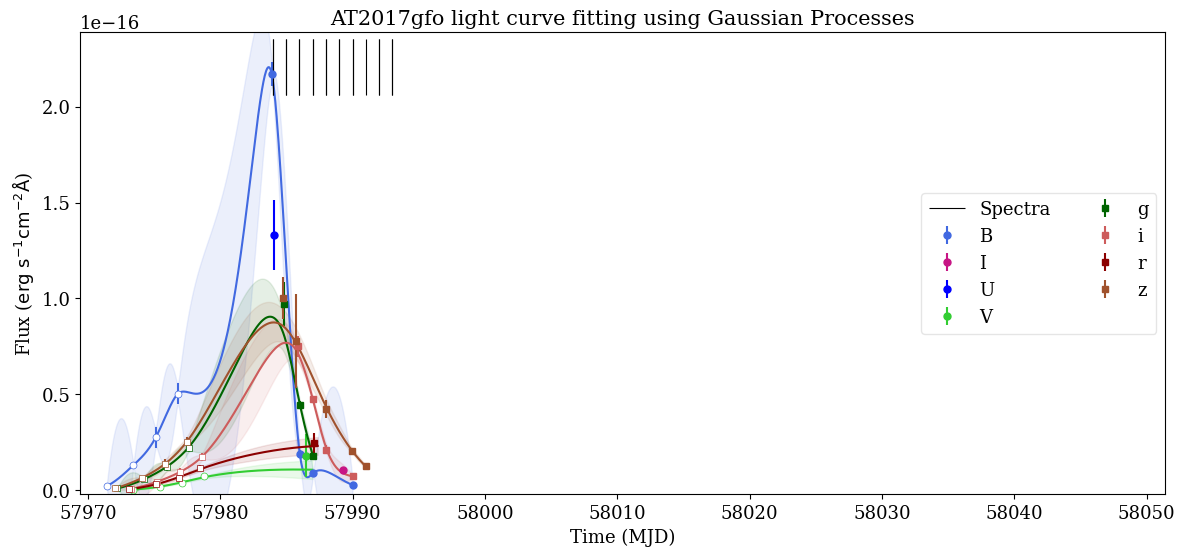

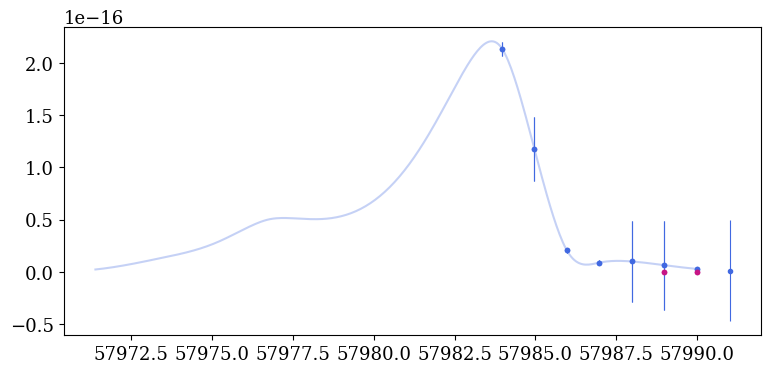

In [29]:
cvs_file=SN.mangling_GPfile()
SN.save_plot_GPfit()
SN.save_plot_GPfit_spec()
#print_separate(SN)

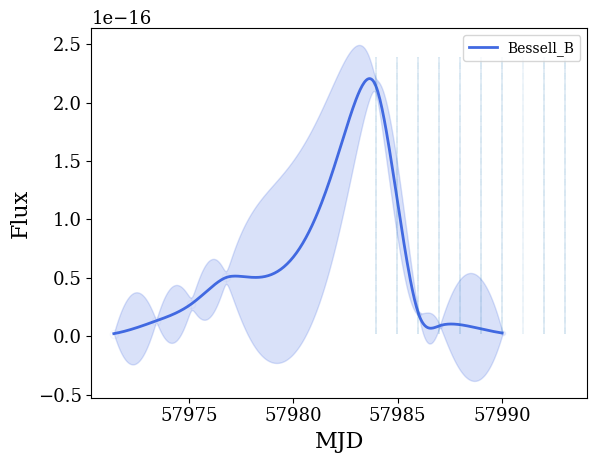

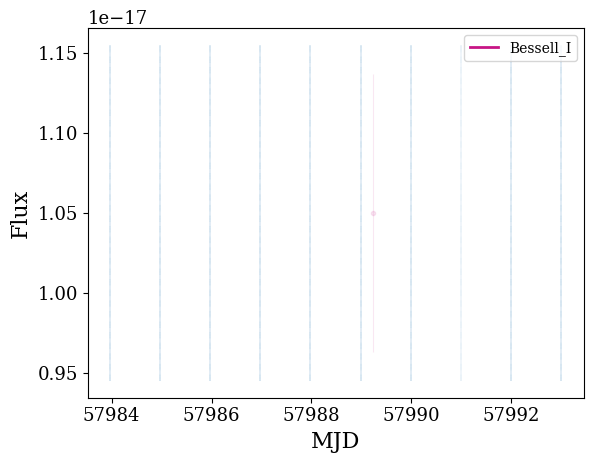

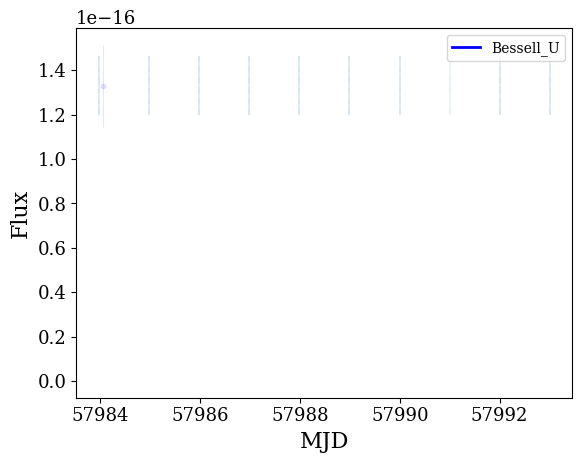

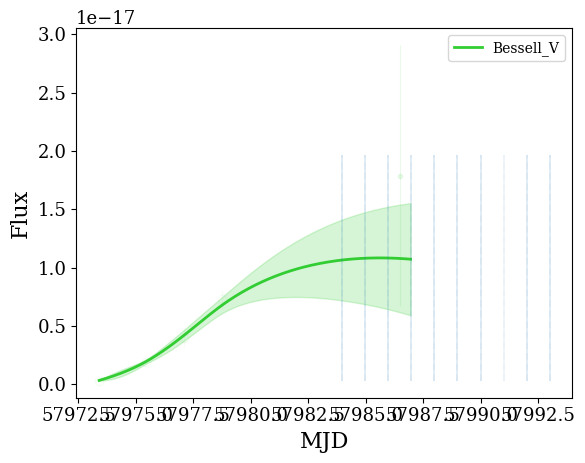

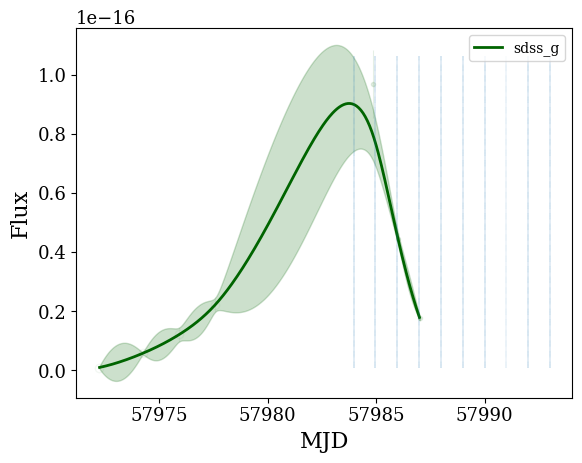

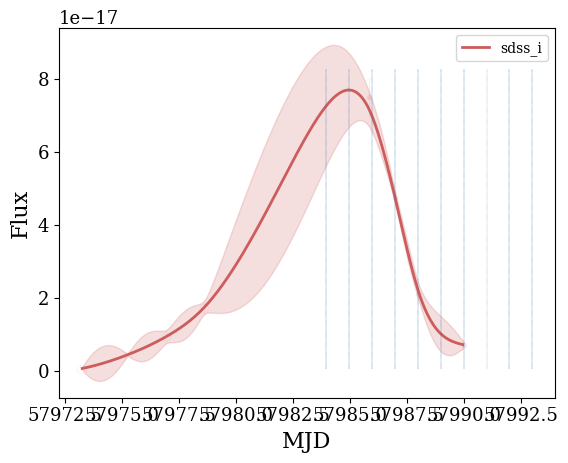

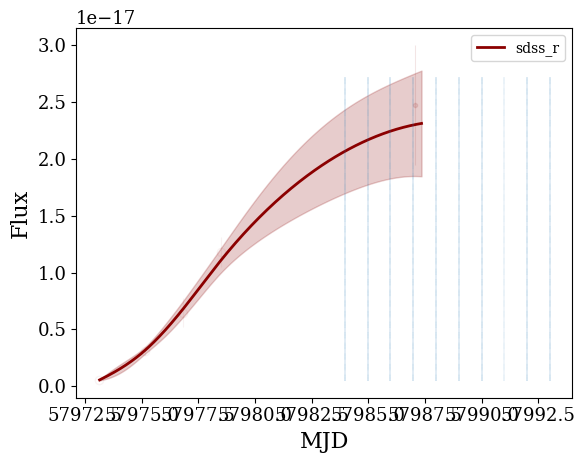

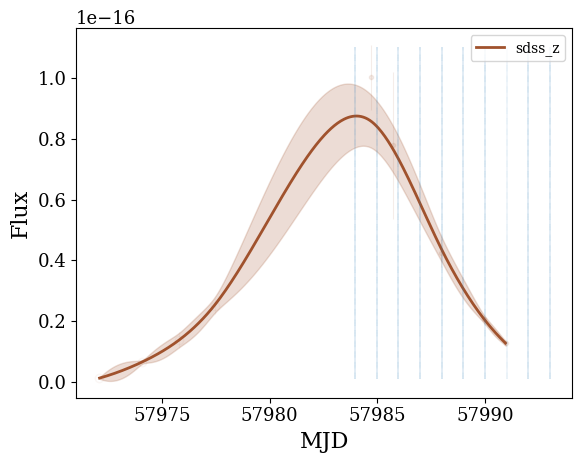

In [30]:
for f in SN.avail_filters:
    #fig = plt.figure(figsize=(10,3))
    c = color_dict[f]
    mjd, flux, err_flux, sudo = SN.fitted_phot[f]['clipped_extended_data'] 
    new_mjd, mu, std= SN.fitted_phot[f]['fit_highcadence'] 
    a=plt.errorbar(mjd[~sudo], flux[~sudo], yerr=err_flux[~sudo], fmt='.', mfc= c, \
               elinewidth=0.8, color= c,linestyle='None', alpha=0.1)
    a=plt.errorbar(mjd[sudo], flux[sudo], yerr=err_flux[sudo], fmt='o', mfc='None', \
               mec=c, elinewidth=0.8, color= c,linestyle='None', alpha=0.05)
    
    plt.plot(new_mjd, mu, color=a[0].get_color(), lw=2.,  label=f)
    plt.fill_between(new_mjd, (mu+std), (mu-std), color=a[0].get_color(), alpha=0.2)
    plt.vlines(SN.get_spec_mjd(), min(flux)*0.9, 1.1*max(flux), linestyle=':', lw=0.3)
    plt.xlabel('MJD', fontsize=16)
    plt.ylabel('Flux', fontsize=16)
    plt.legend()
    plt.show()